#**Credit Card Customers**


The dataset for this project was obtained from an anonymous financial institute that provides loans for individuals, through [Kaggle](https://www.kaggle.com/arjunbhasin2013/ccdata). The objective from this project is to develop customer segmentation as a means to defining marketing strategy for the next campaign.

The sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.



Clustering is a task usually carried out when trying to explore the different groupings of customers for a business, based on shared features. Here we will be exploring kMeans and some of its variations, in addition to Affinity Propagation -all in order to support decision making efforts when deciding on a marketing strategy for the next campaign.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.cluster import AffinityPropagation, estimate_bandwidth, KMeans, MeanShift, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action="ignore")


Let's upload a dataset into google colab

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Credit Card Dataset for Clustering.csv to Credit Card Dataset for Clustering (1).csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Credit Card Dataset for Clustering.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Following is the Data Dictionary for Credit Card dataset :**



**CUST_ID** : Identification of Credit Card holder (Categorical)

**BALANCE** : Balance amount left in their account to make purchases

**BALANCEFREQUENCY** : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

**PURCHASES** : Amount of purchases made from account

**ONEOFFPURCHASES** : Maximum purchase amount done in one-go

**INSTALLMENTSPURCHASES** : Amount of purchase done in installment

**CASHADVANCE** : Cash in advance given by the user

**PURCHASESFREQUENCY** : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

**ONEOFFPURCHASESFREQUENCY** : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

**PURCHASESINSTALLMENTSFREQUENCY** : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

**CASHADVANCEFREQUENCY** : How frequently the cash in advance being paid

**CASHADVANCETRX** : Number of Transactions made with "Cash in Advanced"

**PURCHASESTRX** : Numbe of purchase transactions made

**CREDITLIMIT** : Limit of Credit Card for user

**PAYMENTS** : Amount of Payment done by user

**MINIMUM_PAYMENTS** : Minimum amount of payments made by user

**PRCFULLPAYMENT** : Percent of full payment paid by user

**TENURE** : Tenure of credit card service for user

#**Exploratory Data Analysis**

Let's begin EDA by visualizing some of the variables we have in our dataset:

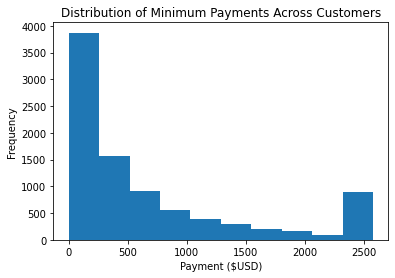

In [5]:
plt.hist(winsorize(data['MINIMUM_PAYMENTS'],(0,0.09)))
plt.title('Distribution of Minimum Payments Across Customers')
plt.xlabel('Payment ($USD)')
plt.ylabel('Frequency')
plt.show()

It would be normal to see most payments being in the lowest bin (0 - 250), and they are. But what about the highest bin where a significant number of customers have a minimum payment of more than $2300 a month?

I would guess that there is a group of big spenders who have a high cap on credit limits within our dataset.

Another question is how frequently customers take cash advances? let's take a look:

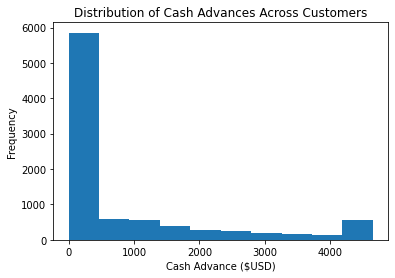

In [6]:
plt.hist(winsorize(data['CASH_ADVANCE'],(0,0.05)))
plt.title('Distribution of Cash Advances Across Customers')
plt.xlabel('Cash Advance ($USD)')
plt.ylabel('Frequency')
plt.show()

Seems like many customers make use of this feature, and just like in the plot above, many take large amounts of cash in advance (over $4000).

##**Data Cleaning**

Since our data here is all numerical, let's begin by taking a look at its quick statistical description:

In [7]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Columns like **BALANCE**, **PURCHASES**, **ONEOFF_PURCHASES** and others have outliers. These should be dealt with in order to have an easier and clearer definition of our clusters.

**Missing Values**

In [8]:
data.isnull().sum().sort_values(ascending=False)

MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
TENURE                                0
PURCHASES_FREQUENCY                   0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
ONEOFF_PURCHASES_FREQUENCY            0
PRC_FULL_PAYMENT                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
PAYMENTS                              0
CUST_ID                               0
dtype: int64

Although missing data in **MINIMUM_PAYMENTS** does not represent much of the dataset, being a numerical variable makes it easy to fill values with the mean of each column:

In [9]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

data = data.drop(columns=['CUST_ID'])

In [10]:
data.isnull().sum().sort_values(ascending=False)

TENURE                              0
ONEOFF_PURCHASES_FREQUENCY          0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
PURCHASES_INSTALLMENTS_FREQUENCY    0
PRC_FULL_PAYMENT                    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
BALANCE                             0
dtype: int64

Now we have no missing values in our dataframe.

##**Feature Engineering**

The feature engineering section will focus on outliers since many of the columns in our dataset have outliers. The good thing is that we have different groups of columns with similar data types and even ranges, which means that binning these columns can help us cluster the data.


These ranges will also prevent loss of data points since binning will help emphasize the difference that we have in our minds to the algorithm:

In [11]:
# The first group: with individual US dollars as units
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

range_min = [0,500,1000,3000,5000]
range_max = [500,1000,3000,5000,10000]
for col in columns:
    bin_col=col+'_BIN'
    data[bin_col]=0
    for i in range(5):
        data.loc[((data[col]>range_min[i])&(data[col]<=range_max[i])),bin_col]=i+1
    data.loc[((data[col]>10000)),bin_col]=6

In [12]:
data = data.drop(columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']) 

In [13]:
# The second group: with frequencies between 0 and 1 as units
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for col in columns:
    bin_col=col+'_BIN'
    data[bin_col]=0
    for i in range(0,10):
        i = i/10
        data.loc[((data[col]>i)&(data[col]<=i+0.1)),bin_col]=int((i+0.1)*10)

In [14]:
data = data.drop(columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'])

In [15]:
# The 3rd group: with number of transactions as units
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']  
for col in columns:
    bin_col=col+'_BIN'
    data[bin_col]=0
    for i in range(0,25,5):
        data.loc[((data[col]>i)&(data[col]<=i+5)),bin_col]=int((i/5)+1)    
    data.loc[((data[col]>25)&(data[col]<=50)),bin_col]=6
    data.loc[((data[col]>50)&(data[col]<=100)),bin_col]=7
    data.loc[((data[col]>100)),bin_col]=8

In [16]:
data = data.drop(columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX'])



#**Clustering**

Next, we define our features as a numpy array, then we scale the data using the Scikit-Learn StandardScaler in preparation to feed it to the kMeans algorithm:

In [17]:
X= np.asarray(data)
scale = StandardScaler()
X = scale.fit_transform(X)

##**Kmeans**


The way we will approach kMeans first is using inertia to evaluate its performance. Inertia is defined as the sum of squares within a cluster. Through comparing inertia among several values of k, we can have an idea on what value we will be choosing:

In [18]:
n_clusters=8
inertia=[]
k = []
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    inertia.append(kmean.inertia_)  
    k.append(i)


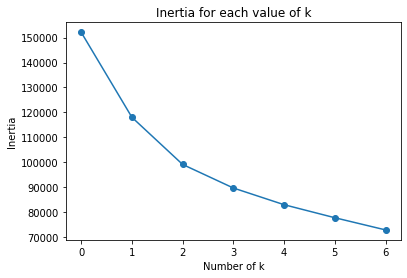

In [19]:
plt.plot(inertia, 'o-')
plt.title('Inertia for each value of k')
plt.xlabel('Number of k')
plt.ylabel('Inertia')
plt.show()


It seems like 6 clusters is a good value to start from, having the least inertia, meaning it has the most coherent distribution of data points within 6 clusters.



In [20]:
kmean= KMeans(6)
dist = 1 - cosine_similarity(X)
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)

kmean.fit(X)
labels=kmean.labels_

In [21]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_BIN,PURCHASES_BIN,ONEOFF_PURCHASES_BIN,INSTALLMENTS_PURCHASES_BIN,CASH_ADVANCE_BIN,CREDIT_LIMIT_BIN,PAYMENTS_BIN,MINIMUM_PAYMENTS_BIN,BALANCE_FREQUENCY_BIN,PURCHASES_FREQUENCY_BIN,ONEOFF_PURCHASES_FREQUENCY_BIN,PURCHASES_INSTALLMENTS_FREQUENCY_BIN,CASH_ADVANCE_FREQUENCY_BIN,PRC_FULL_PAYMENT_BIN,PURCHASES_TRX_BIN,CASH_ADVANCE_TRX_BIN,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,1
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,5
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,2
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,1
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,1


#**Visualization of Cluster Features**

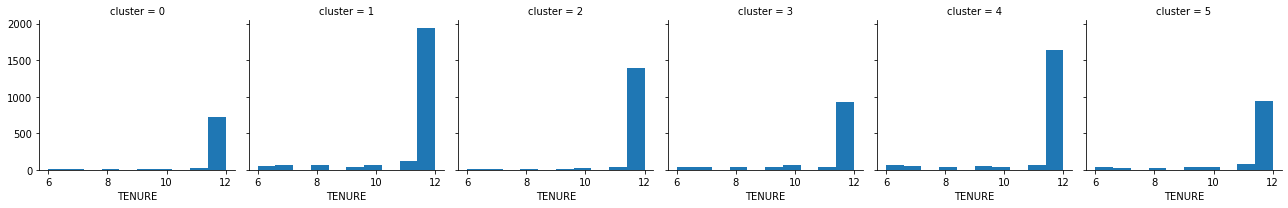

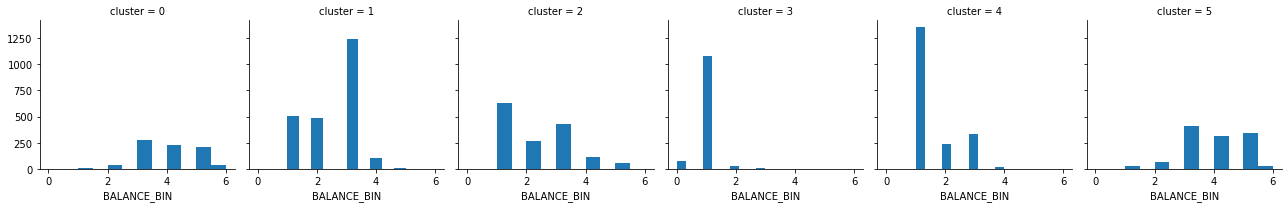

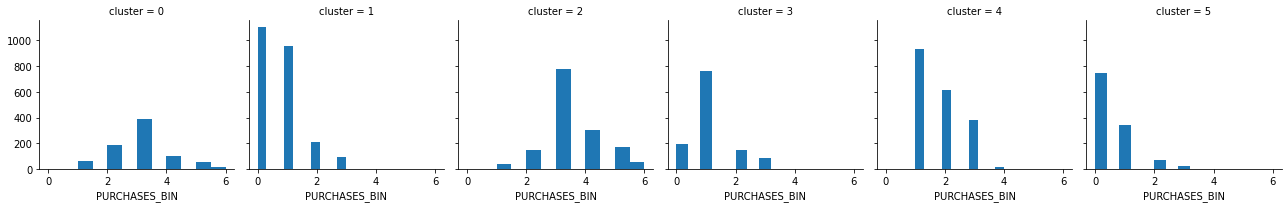

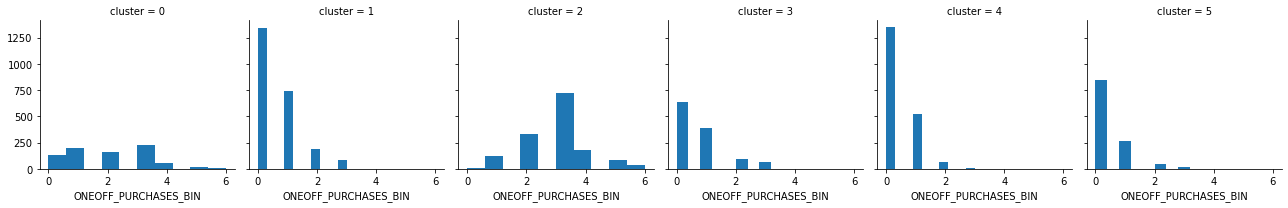

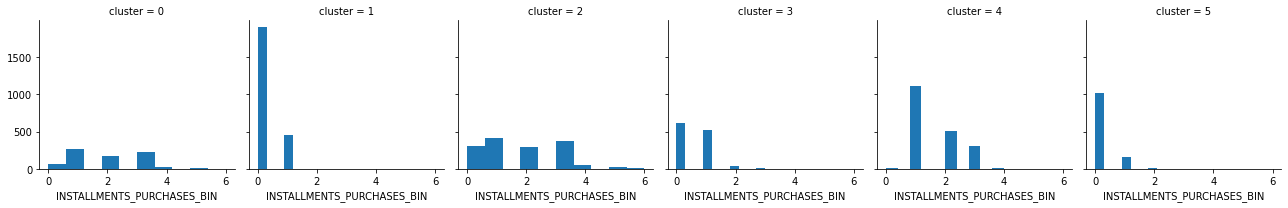

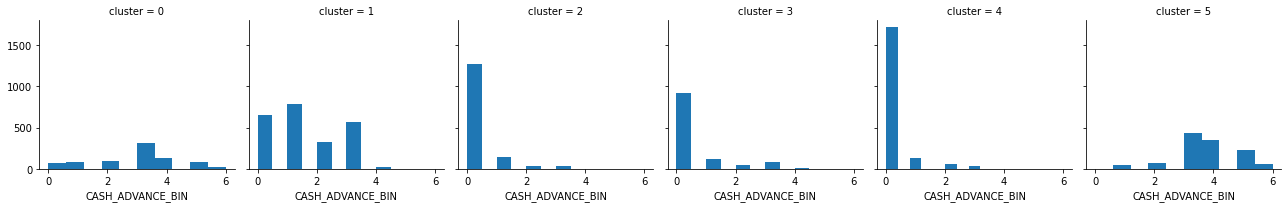

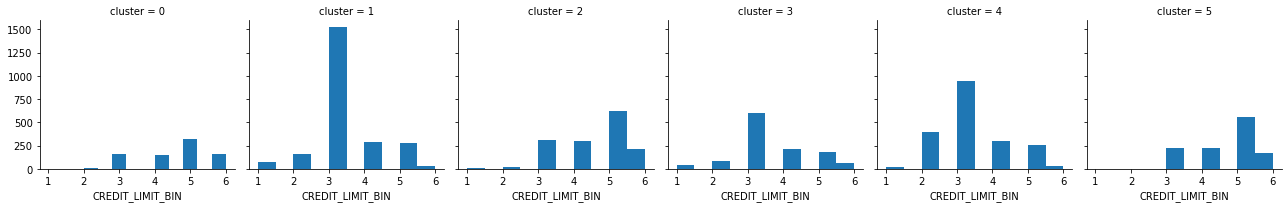

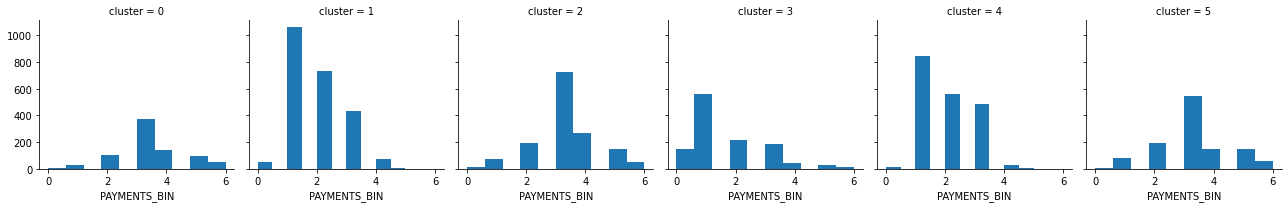

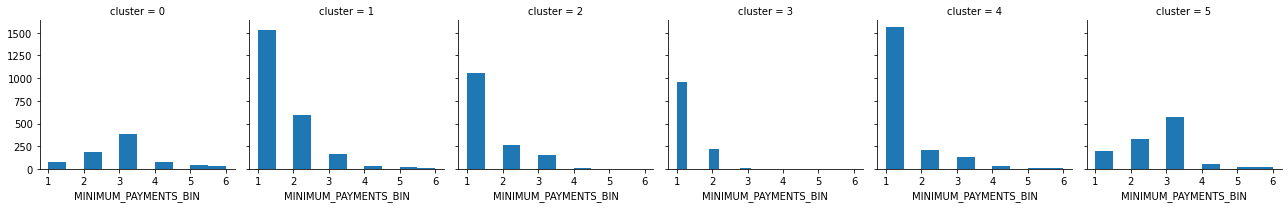

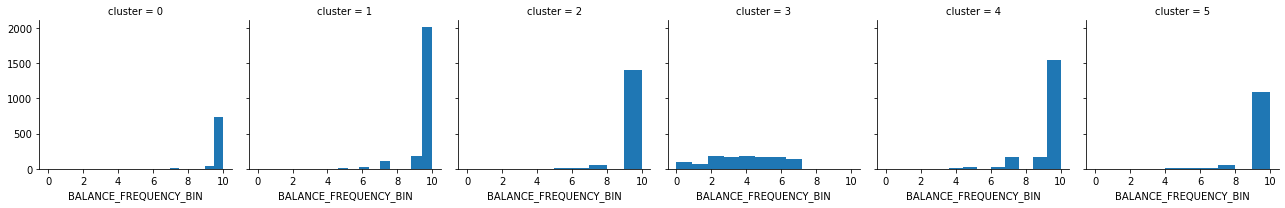

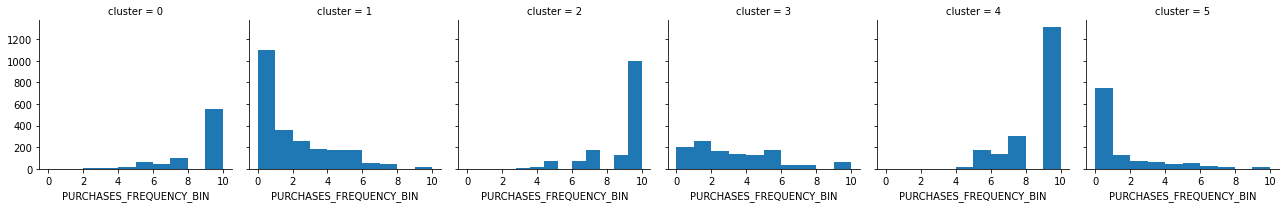

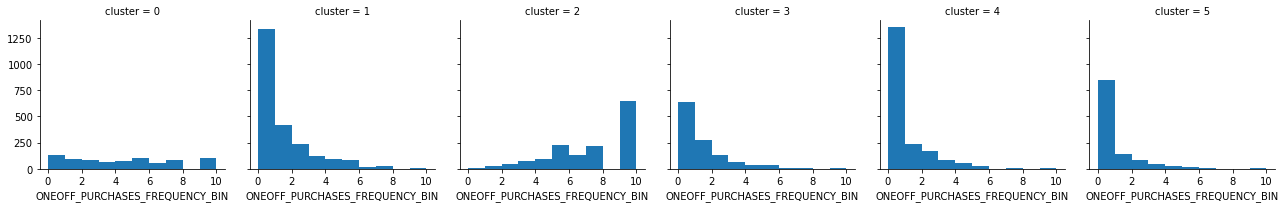

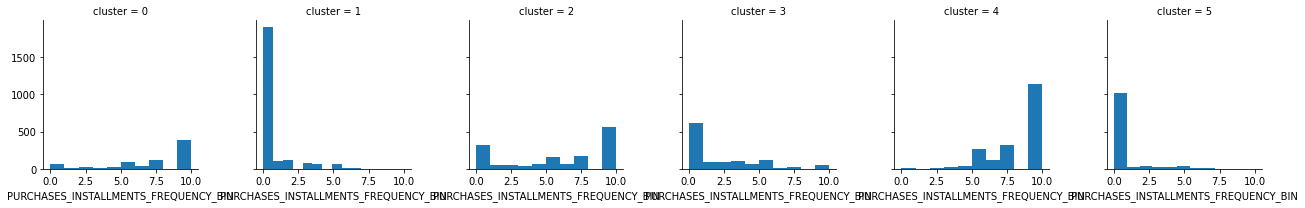

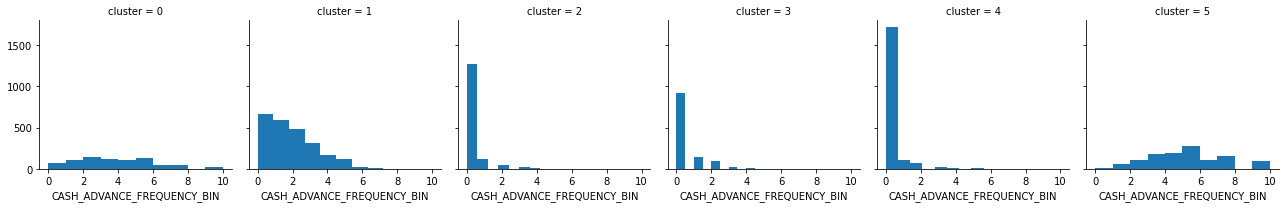

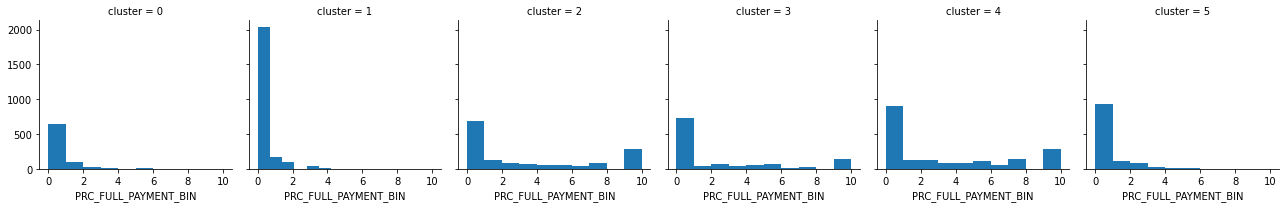

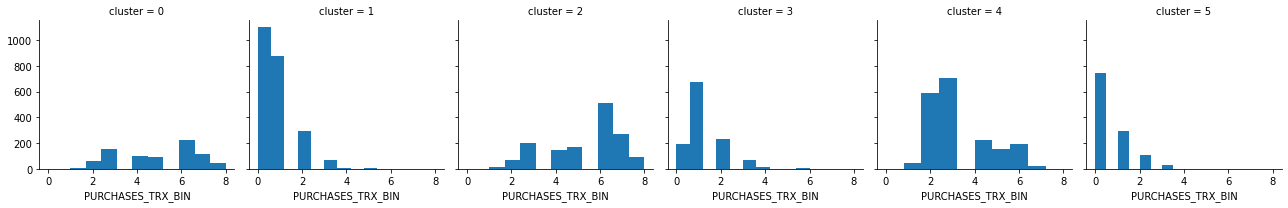

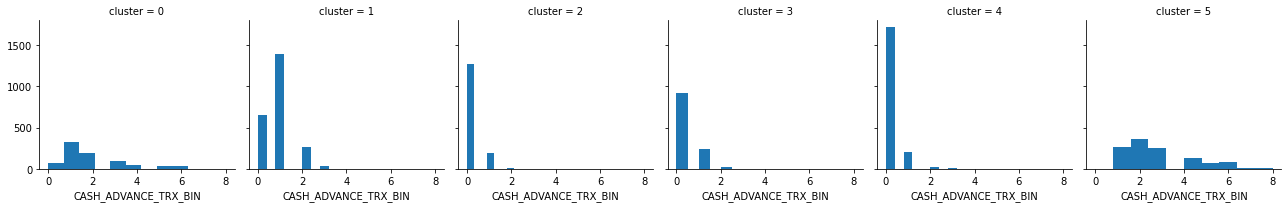

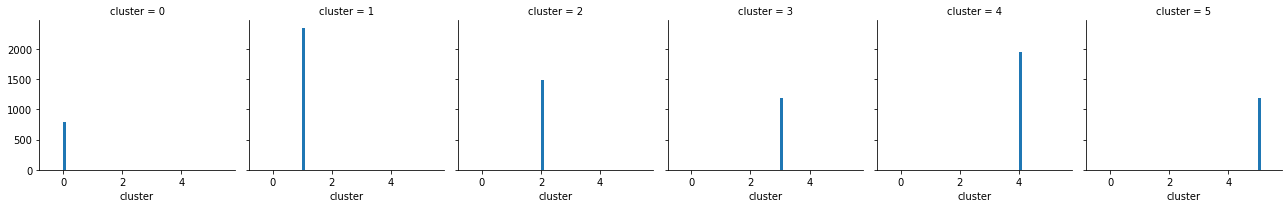

In [22]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

**Cluster Highlights**

* **Cluster0** Average credit limit, mostly small to medium purchases, they often make use of cash advances.

* **Cluster1** Rarely takes cash advances but makes a lot of purchases. Average to high credit limit and more payment amounts.

* **Cluster2** Same credit limit as cluster 1. Usually doesn't purhcase with full payment and doesn't spend much in general.

* **Cluster3** Average to high credit cluster with customers who take more cash in advance

* **Cluster4** Average credit limit with a distributed purchase frequency.

* **Cluster5** Average to high credit limit customers who do not make much use of their credit cards.

Visualizing these clusters with PCA will make them into an isotropic shape that makes it clearer to see each cluster and where its customers fall within the larger sample:

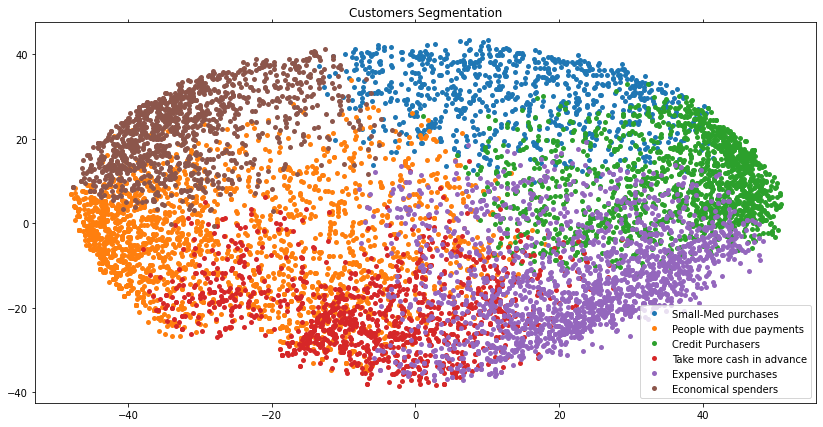

In [23]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'Small-Med purchases', 
         1: 'People with due payments', 
         2: 'Credit Purchasers', 
         3: 'Take more cash in advance', 
         4: 'Expensive purchases',
         5:'Economical spenders'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(14, 7)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation")
plt.show()

We can see how clusters are dense around the shape in the plot, taking a different side each. The higher up we go in the y-axis, the more credit these clusters are availing.

**Usage**

This document provides a way for financial institutes to cluster their individual credit customers into groups. As market needs evolve, the clusters in here may change accordingly. This clustering can result in beneficial input that can be used in targeting these customers within a marketing strategy and design services that fit their needs.

#**Other Clustering Approaches**

We will try other clustering approaches basing our analysis on purchase frequency:

In [24]:
X = data.drop(columns=['PURCHASES_FREQUENCY_BIN'])
y = data['PURCHASES_FREQUENCY_BIN']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

#**MeanShift**

Mean shift makes no assumptions about the nature of the data or the number of clusters, making it more versatile than 𝑘-means, but it creates clusters where data points form a "globe" around a central point. It works for data sets where many clusters are suspected.

Let's see how MeanShift clusters our dataset based on purchase frequency:

In [25]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))


print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


The number of estimated clusters is certainly not 1. We know that through the values we have seen before and the differences in customer behavior throughout features in this dataset.

Also logically, we cannot expect customers to have a uniform behavior given almost any community regardless of the size.

#**Affinity Propagation**

This algorithm is based on the idea of data points' ability to represent each other through similarity.

It defines a similarity matrix that helps in understanding similarity of these points to each other. Then there would be a clustering matrix where similarity has been decided and the algorithm goes towards maximizing similarity for cluster coherence.

It uses availability and responsibility as parameters to deciding how cluster coherence is maximized. Candidate exemplar points send availability information to points which would be in its cluster, their response would be responsibility.

All of this is encompassed in the next block of code, showing the work of Affinity Propagation:

In [26]:
# Declare the model and fit it.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 44


It is common for Affinity Propagation to overestimate the number of clusters, which is the case in our data.

Logically, we cannot have 44 types of customers, even for a global company that literally has branches in each country. This case would only exist in companies that have customers for different product lines, but that would still make them incomparable.

#**Conclusion**


The reason that kMeans is most widely used in clustering may not be because it works every time, but probably due to its logical handling of data and logical output of clusters.

Although there are benefits to using other clustering algorithms. These benefits may not come to light in such a small project, but more in a constant effort where clustering is really needed, and variations of clustering would come in handy to solve more specific issues in grouping data points.

We did not even have to evaluate MeanShift and Affinity Propagation model clusters using metrics due to the cluster output being absurd and illogical, where the kMeans performed much better and gave output that could be interpreted by humans, businesses, and could produce value for a marketing manager trying to look at a high-level segmentation of their company's customers.